# Predicting Car Crashes and Injuries
 By Kevin, Pradeep, Sangrae, and DJ

## Table of contents

1. [The Problem](#problem)
2. [Setup](#setup)
3. [Load](#load)
4. [Cleanup](#cleanup)
    1. [Targets](#targets)
    2. [First Pass](#firstpass)
    3. [Missing Data Analysis](#missing)
        1. [Missingness Over Time](#timemissing)
        2. [Missingness Across Space](#spacemissing)
        3. [Crash Rates](#crashratesmissing)
        4. [Accidents with Injuries](#injuryaccidentsmissing)
        5. [Number of Fatal Injuries](#fatalaccidentmissing)
    4. [Second Pass](#secondpass)
5. [Logistic Regression](#logistic)

## The Problem <a name='problem'></a>

Traffic collisions range from benign to catastrophic. Ideally, we would want a stronger first responder presence in areas where we expect more serious collisions. Our goal is to predict the number of collisions in every police beat in Chicago during a single shift, whether there are injuries in a given accident, and the severity of those injuries. 

We use a hidden markov model to leverage spatial and temporal data to predict the number of crashes in a given beat during a shift. We will then sample from the posterior and create a chloropleth map that shows the predicted number of accidents per beat in a given shift. The number of injuries in a given accident can be predicted using a zero-inflated poisson model. We measure the severity of injuries by counting the number of fatal and incapacitating injuries in a given accident.

## Setup <a name='setup'></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from multiprocessing import cpu_count
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import pomegranate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats


pd.set_option('display.max_columns', 999)

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"



## Load <a name='load'></a>

Categorical variables are typed as abstract objects by default, so we explicitly tell pandas to type them as categories. We are also aware that there are 'UNKNOWN' values in the dataset that should be read as missing, so we pass a list containing 'UNKNOWN' to read_csv. 

In [4]:
categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
                'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE',
                'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE',
                'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE','BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I',
                'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'INJURIES_UNKNOWN']
dtypes = dict.fromkeys(categoricals, 'category')

In [5]:
data = pd.read_csv('../../data/trafficcrasheschicago.zip', parse_dates = ['CRASH_DATE'],
                   dtype=dtypes, na_values = ['UNKNOWN', 'UNABLE TO DETERMINE'])
data.head(3)

,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,JC334993,NaN,2019-07-04 22:33:00,45,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",07/04/2019 11:05:00 PM,FOLLOWING TOO CLOSELY,NOT APPLICABLE,300,N,LAKE SHORE DR SB,114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,5,7,41.886140,-87.614274,POINT (-87.614274106164 41.8861404879)
1,JC370822,NaN,2019-07-30 10:22:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",07/30/2019 10:25:00 AM,FAILING TO YIELD RIGHT-OF-WAY,IMPROPER TURNING/NO SIGNAL,8201,S,DR MARTIN LUTHER KING JR DR,631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3,7,41.745549,-87.614670,POINT (-87.614669906271 41.745549113377)
2,JC387098,NaN,2019-08-10 17:00:00,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"$501 - $1,500",08/10/2019 05:35:00 PM,EQUIPMENT - VEHICLE CONDITION,NOT APPLICABLE,6747,S,CREGIER AVE,332,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,7,8,41.772004,-87.581234,POINT (-87.58123401629 41.772004323752)


## Cleanup <a name='cleanup'></a>

### Targets <a name='targets'></a>

### First Pass <a name='firstpass'></a>

We begin by checking our assumptions for the variables in the dataset. We will begin with the numeric data.

In [30]:
data.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,377630.000000,1.985490e+05,377630.000000,376172.000000,375403.000000,375403.000000,375403.00000,375403.000000,375403.000000,375403.000000,377630.000000,377630.000000,377630.000000,375627.000000,375627.000000
mean,28.244758,1.335580e+01,3580.168864,2.020719,0.163496,0.000882,0.01773,0.089070,0.055815,2.025890,13.180062,4.121158,6.909215,41.858157,-87.671980
std,6.662733,2.965030e+03,2906.301644,0.416721,0.523002,0.032261,0.15566,0.383158,0.301246,1.160255,5.455058,1.965998,3.454893,0.358471,0.731744
min,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-87.934014
25%,30.000000,2.000000e+00,1199.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,9.000000,2.000000,4.000000,41.788098,-87.720411
50%,30.000000,2.000000e+00,3100.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,14.000000,4.000000,7.000000,41.878217,-87.672417
75%,30.000000,4.000000e+00,5500.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,17.000000,6.000000,10.000000,41.924989,-87.632837
max,99.000000,1.191625e+06,451100.000000,18.000000,21.000000,3.000000,7.00000,21.000000,10.000000,61.000000,23.000000,7.000000,12.000000,42.022780,0.000000


The posted speed limit variable contains nonsensical values, so we will have to clean that up. STREET_NO doesn't seem useful, so we will delete that column. NUM_UNITS and the remaining variables all have reasonable statistics except for LANE_CNT, LATITUDE, and LONGITUDE. For some reason, there are zero values for latitude and longitude. We should impute these values using the latitudes and longitudes of car accidents in the corresponding police beat. LANE_CNT has unreasonably large values, but it is believable that a crash could occur with 0 lanes if the crash occurred off the road. Given that we don't know the details of what 0 means, the safe bet is to leave it there. Most of the numeric variables have a significant right skew.

Notice the lack of skew in the CRASH_MONTH and CRASH_DAY_OF_WEEK variables. This uniformity contradicts our expectations. There also appear to be lower accident rates during really early and late hours as we'd expect. 

In [6]:
# Non-sensical peed limit Values replaced with nan. I've never seen a speed limit lower than 15.
data['POSTED_SPEED_LIMIT'] = data['POSTED_SPEED_LIMIT'].apply(lambda x: x if x % 5 == 0 and x > 10 else np.nan)

Now we turn to the categorical columns.

In [32]:
data.describe(include=['category'])

,CRASH_DATE_EST_I,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,INJURIES_UNKNOWN
count,28062,365350,357105,361341,364004,377630,373464,377630,352837,323824,368884,377630,83409,17401,104899,377630,241111,243525,377626,4781,7624,1264,2646,1825,617,375403
unique,2,18,7,10,5,18,19,6,6,6,2,2,2,2,2,3,39,39,274,2,2,2,2,3,2,1
top,Y,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,Y,Y,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,1834,Y,Y,Y,Y,CONSTRUCTION,Y,0
freq,24356,217363,219376,298351,247573,93358,171443,368274,282400,314890,229370,291294,79491,15902,100355,212956,42400,150493,5546,3729,6200,864,2100,1499,554,375403


We can immediately see several problems. CRASH_DATE_EST_I, DOORING_I, PHOTOS_TAKEN_I, STATEMENTS_TAKEN_I, NOT_RIGHT_OF_WAY_I, INTERSECTION_RELATED_I and the WORK_ variables have an incredible amount of missing data and INJURIES_UNKNOWN only has one unique value. We should throw away INJURIES_UNKNOWN and consider throwing away CRASH_DATE_EST_I and the WORK_ variables. We will look into these variables in-depth in the missing data analysis.

We can see that there is another unidentified pseudo-missing value labeled 'UNABLE TO DETERMINE' under the PRIM_CONTRIBUTORY_CAUSE variable. When this notebook is finalized, we will adjust the read_csv function to account for this at the beginning. 

There is some target leakage in CRASH_TYPE because some of its values describe whether there was an injury or not, so we should start combining factors so that our model doesn't know whether there were injuries ahead of time while fitting. 

### Missing Data Analysis <a name='missing'></a>

First, let's check the missingness by variable.

In [8]:
# Missingness by  variable
missing_by_var = data.isnull().sum()/data.shape[0]
missing_by_var

RD_NO                            0.000000
CRASH_DATE_EST_I                 0.925689
CRASH_DATE                       0.000000
POSTED_SPEED_LIMIT               0.046315
TRAFFIC_CONTROL_DEVICE           0.032519
DEVICE_CONDITION                 0.054352
WEATHER_CONDITION                0.043135
LIGHTING_CONDITION               0.036083
FIRST_CRASH_TYPE                 0.000000
TRAFFICWAY_TYPE                  0.011032
LANE_CNT                         0.474223
ALIGNMENT                        0.000000
ROADWAY_SURFACE_COND             0.065654
ROAD_DEFECT                      0.142483
REPORT_TYPE                      0.023160
CRASH_TYPE                       0.000000
INTERSECTION_RELATED_I           0.779125
NOT_RIGHT_OF_WAY_I               0.953921
HIT_AND_RUN_I                    0.722218
DAMAGE                           0.000000
DATE_POLICE_NOTIFIED             0.000000
PRIM_CONTRIBUTORY_CAUSE          0.361515
SEC_CONTRIBUTORY_CAUSE           0.355123
STREET_NO                        0

Several variables have a large number of missing values. Many may have to be dropped, but we should see how the distributions of our dependent variables change between missing and non-missing values for these variables. It will also interest us to see how missingness changes across time and space.



##### Missingness Over Time <a name='timemissing'></a>

If we assume that there is no time varying component that contributes to the missingness of a given value, then we can model missingness over time as a random walk on the integers where the traveller can either stand in place or move one step forward at each time period. This will be used to construct the reference processes against which we can compare cumulative missingness of our variables. 

A binomial process is typically paramterized by p, the probability of one event occurring (assuming there are only 2 possible outcomes at each trial). Under our assumptions of independence, we can estimate p by transforming each variable into an indicator variable by using the isnull() method. By definition, every probability is the expected value of some indicator function over an observational space. Therefore, the empirical expectations of the mean of the columns in their indicator form will be an unbiased estimate of the probability p. 

Another way to think about this is to suppose that we made robotic police officers that are consistent but randomly mess up as much as the human officers in the long run. We are comparing the real life police officers to these fake robot police officers. We're interested in times when the real life police officers do better than the robot police officers at recording data and vice-versa.

In [9]:
filt = missing_by_var > 0.01
missing_cols = data.set_index('CRASH_DATE').loc[:,filt]


#Cumulative missing
missing_cols = missing_cols.sort_index().isnull()  # indicator variable for missingness
missing_weights = missing_cols.sum()/missing_cols.shape[0]
missing_array = missing_weights.values
cumulative_missing = missing_cols.cumsum()  # cumulative summation

cumulative_missing

,CRASH_DATE_EST_I,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,LANE_CNT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I
CRASH_DATE,,,,,,,,,,,,,,,,,,,,,,
2013-03-03 16:48:00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1
2014-01-18 18:14:00,2,0,0,0,0,0,0,1,0,0,0,1,2,1,1,1,2,2,2,2,2,2
2014-01-21 07:40:00,3,0,0,0,0,0,0,2,0,0,0,2,3,2,1,1,3,3,3,3,3,3
2014-02-24 19:45:00,4,0,0,0,0,0,0,3,0,0,0,3,4,3,2,2,4,4,4,4,4,4
2014-06-25 19:00:00,5,0,0,0,0,0,0,4,0,1,0,4,5,3,2,2,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-16 23:22:00,349564,17490,12280,20525,16289,13626,4166,179077,24793,53806,8746,294219,360225,272728,136518,134105,372845,370002,376362,374980,375801,377009
2020-01-16 23:23:00,349565,17490,12280,20525,16289,13626,4166,179078,24793,53806,8746,294219,360226,272728,136519,134105,372846,370003,376363,374981,375802,377010
2020-01-16 23:30:00,349566,17490,12280,20525,16289,13626,4166,179079,24793,53806,8746,294219,360227,272729,136519,134105,372847,370004,376364,374982,375803,377011


In [11]:
#sample from binomial distributions and cumulative percentage for that
#note that we really want to sample the entire process multiple times to reduce simulation error.

samples = np.array([np.random.binomial(1, missing_array, (missing_cols.shape[0], missing_cols.shape[1])) for process in range(10)])
samples = samples.cumsum(axis=1).mean(axis=0)
samples = pd.DataFrame(samples, index=missing_cols.index, columns=missing_cols.columns)
samples

,CRASH_DATE_EST_I,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFICWAY_TYPE,LANE_CNT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I
CRASH_DATE,,,,,,,,,,,,,,,,,,,,,,
2013-03-03 16:48:00,1.0,0.1,0.0,0.1,0.1,0.0,0.0,0.5,0.2,0.3,0.1,0.8,1.0,0.8,0.2,0.1,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-18 18:14:00,1.8,0.1,0.1,0.3,0.1,0.1,0.0,0.6,0.2,0.5,0.1,1.5,1.9,1.4,0.7,0.6,1.9,2.0,2.0,2.0,2.0,2.0
2014-01-21 07:40:00,2.8,0.1,0.1,0.4,0.1,0.1,0.0,1.0,0.3,0.8,0.3,2.4,2.8,2.1,1.1,0.8,2.9,3.0,3.0,3.0,3.0,2.9
2014-02-24 19:45:00,3.8,0.1,0.1,0.6,0.1,0.1,0.0,1.3,0.6,1.0,0.4,3.4,3.8,2.8,1.3,1.2,3.9,4.0,4.0,4.0,4.0,3.9
2014-06-25 19:00:00,4.6,0.2,0.1,0.6,0.1,0.2,0.0,2.0,0.6,1.1,0.5,4.1,4.8,3.7,1.6,1.2,4.9,5.0,5.0,5.0,5.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-16 23:22:00,349601.3,17518.5,12265.6,20596.2,16354.0,13625.0,4165.6,179158.7,24826.5,53759.4,8747.0,294297.7,360294.1,272736.3,136526.0,134165.6,372829.4,369976.7,376366.1,374994.2,375803.5,377017.2
2020-01-16 23:23:00,349602.2,17518.6,12265.7,20596.3,16354.1,13625.0,4165.6,179159.3,24826.6,53759.4,8747.0,294298.6,360295.0,272737.0,136526.3,134165.8,372830.4,369977.7,376367.1,374995.2,375804.5,377018.2
2020-01-16 23:30:00,349603.2,17518.7,12265.7,20596.3,16354.1,13625.0,4165.7,179160.0,24826.7,53759.5,8747.2,294299.2,360296.0,272737.9,136526.7,134166.2,372831.4,369978.7,376368.1,374996.2,375805.5,377019.2


We now subtract our reference values from our empirical values to get our matrix of summary statistics and plot the columns. We'll start with one plot so that we can guide the reader through the interpretation of the plots. If the binomial process models the variables well, we should see roughly straight lines hovering around 0. 

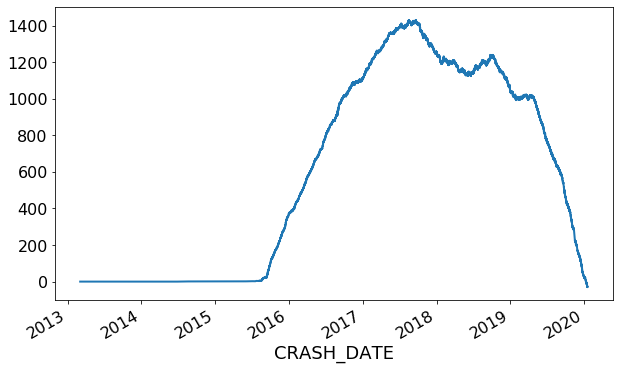

In [14]:
diff = cumulative_missing - samples
diff['POSTED_SPEED_LIMIT'].plot()

The plot above shows that the binomial model fits well for the 2013 to 2016 period, but then the real officers start performing worse than the fake police officers from late 2015 to the middle of 2017. Then, for some unknown reason, police officers immediately start catching up with the robot police officers, especially starting in 2019. The sharpest drop in performance happens from 2019 to 2020. To get a different view of the rates of change, we can take a first difference of the data. We'll take a very large difference in the time series since the series is so massive and noisy that it hides the underlying reality. Obviously, this will get rid of some data, but the later periods are of greater interest to us anyway. 

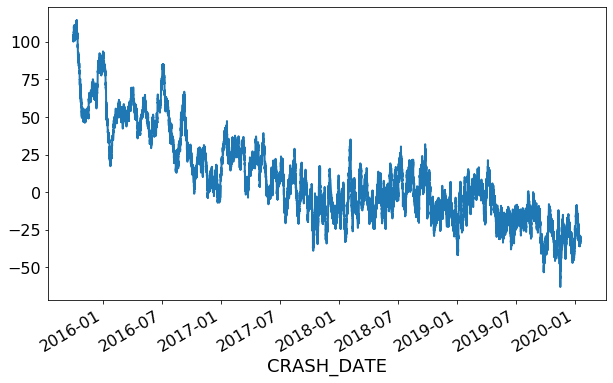

In [27]:
diff['POSTED_SPEED_LIMIT'].diff(periods=2000).plot()

The police officers are getting relatively worse at a slower rate and then they start doing better and better in 2018. Stakeholders may want to see what changed. Let's see if the other variables also tell interesting stories.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


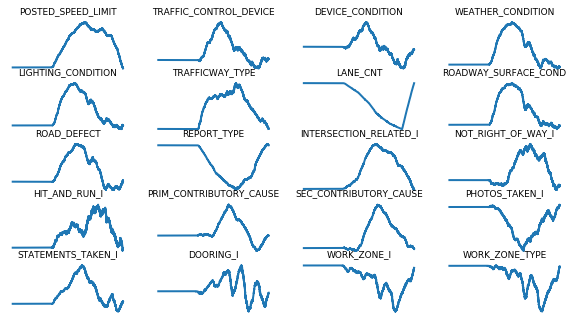

In [38]:
for i in range(1,21):
    plt.subplot(5,4,i)
    plt.title(diff.columns[i], fontsize=9)
    plt.axis('off')
    diff.iloc[:,i].plot()


The story here is not that the police and the robots eventually catch up with each other. The have to eventually catch up because we programmed them to do that. The journey is what's important, not the destination. How did the data break from the model? 

The first interesting thing to note is that all of the variables started breaking from the model at around the same time, some of them more extremely than others. Increases mean the police are doing worse than the robots; decreases mean the police are doing better than the robots.

What we can definitely make of this is that missingness strongly depends on time and stakeholders should investigate these charts and wonder to themselves why the real police officers broke away from expectations in the way they did.

#### Missingness Across Space <a name='spacemissing'></a>

#### Crash Rates <a name='crashratesmissing'></a>

In [35]:
# Let's track the cumulative percentage missingness across time for all of the missing variables to see
# if there is a time component to the missingness.



AttributeError: module 'seaborn' has no attribute 'subplot'

#### Accidents with Injuries <a name='injuryaccidentsmissing'></a>

#### Number of Fatal Injuries <a name='fatalaccidentmissing'></a>

### Second Pass <a name='secondpass'></a>

## Variable Importance

### Logistic Regression <a name='logistic'></a>

In [60]:
# Number of available cores for fitting
from multiprocessing import cpu_count
cores = cpu_count() - 1

# Create Target Variable
data['INJURIES'] = data['INJURIES_TOTAL'].apply(lambda x: 1 if x>0 else 0)

# Validation and Test sets
validation_set = data.query('CRASH_DATE >= \'2019-01-01\' and CRASH_DATE < \'2019-11-01\'')
test_set = data.query('CRASH_DATE >= \'2019-11-01\'')
validation_set = validation_set.set_index('CRASH_DATE')
test_set = test_set.set_index('CRASH_DATE')

# Drop target, leaky vars, and useless vars from features set
features = validation_set.drop(['INJURIES', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
                      'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
                      'NUM_UNITS'], axis=1)

target = validation_set['INJURIES']

numerical_vars = list(features.select_dtypes(['int64', 'float64']))
num_pipe = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

categorical_vars = list(features.select_dtypes(['category']))
cat_pipe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_vars),
    ('cat', cat_pipe, categorical_vars)
])

clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000))
])

logistic_grid = {'classifier__C': np.linspace(0, 5, 100)}
tss = TimeSeriesSplit(n_splits = 5)

gs = GridSearchCV(clf, param_grid=logistic_grid, cv=tss, n_jobs=cores, scoring='neg_log_loss')

In [61]:
gs.fit(features, target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('num_impute',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                          

In [63]:

best_process = gs.best_estimator_
best_model = gs.best_estimator_[1]
X_test = test_set.drop(['INJURIES', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
                        'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
                        'NUM_UNITS'], axis=1)
target_test = test_set['INJURIES']
pred = best_process.predict(X_test)

print(classification_report(target_test, pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98     20003
           1       0.94      0.76      0.84      3049

    accuracy                           0.96     23052
   macro avg       0.95      0.88      0.91     23052
weighted avg       0.96      0.96      0.96     23052

